# Credit Card Fraud Detection

This notebook implements a comprehensive fraud detection system using machine learning techniques.

## Table of Contents
1. [Setup and Imports](#1-setup-and-imports)
2. [Data Loading and Exploration](#2-data-loading-and-exploration)
3. [Data Preprocessing](#3-data-preprocessing)
4. [Handling Imbalanced Data](#4-handling-imbalanced-data)
5. [Model Training](#5-model-training)
6. [Model Evaluation](#6-model-evaluation)
7. [Results Summary](#7-results-summary)

## 1. Setup and Imports

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
    
# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve, auc
)

# XGBoost
from xgboost import XGBClassifier

# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Data Loading and Exploration

### 2.1 Load Dataset

The dataset can be downloaded from Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud

We'll use kagglehub to download the dataset automatically.

In [2]:
# Download dataset from Kaggle
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print(f"Dataset downloaded to: {path}")

# Load the dataset
df = pd.read_csv(os.path.join(path, "creditcard.csv"))
print(f"Dataset shape: {df.shape}")

Dataset downloaded to: C:\Users\nzx19\.cache\kagglehub\datasets\mlg-ulb\creditcardfraud\versions\3
Dataset shape: (284807, 31)


### 2.2 Basic Dataset Information

In [3]:
# Display first few rows
print("First 5 rows of the dataset:")
df.head()

First 5 rows of the dataset:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Dataset info
print("Dataset Information:")
print("-" * 50)
df.info()

Dataset Information:
--------------------------------------------------
<class 'pandas.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  

In [5]:
# Statistical summary
print("Statistical Summary:")
df.describe()

Statistical Summary:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.175161e-15,3.384974e-16,-1.379537e-15,2.094852e-15,1.021879e-15,1.494498e-15,-5.620335e-16,1.149614e-16,-2.414189e-15,...,1.628620e-16,-3.576577e-16,2.618565e-16,4.473914e-15,5.109395e-16,1.686100e-15,-3.661401e-16,-1.227452e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### 2.3 Check for Missing Values and Duplicates

In [6]:
# Check for missing values
missing_values = df.isnull().sum().sum()
print(f"Total missing values: {missing_values}")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Total duplicate rows: {duplicates}")

if duplicates > 0:
    print(f"\nRemoving {duplicates} duplicate rows...")
    df = df.drop_duplicates()
    print(f"New dataset shape: {df.shape}")

Total missing values: 0
Total duplicate rows: 1081

Removing 1081 duplicate rows...
New dataset shape: (283726, 31)


### 2.4 Class Distribution Analysis

In [7]:
# Class distribution
class_counts = df['Class'].value_counts()
class_percentages = df['Class'].value_counts(normalize=True) * 100

print("Class Distribution:")
print("-" * 30)
print(f"Legitimate (0): {class_counts[0]:,} ({class_percentages[0]:.3f}%)")
print(f"Fraudulent (1): {class_counts[1]:,} ({class_percentages[1]:.3f}%)")
print(f"\nImbalance Ratio: {class_counts[0]/class_counts[1]:.1f}:1")

Class Distribution:
------------------------------
Legitimate (0): 283,253 (99.833%)
Fraudulent (1): 473 (0.167%)

Imbalance Ratio: 598.8:1


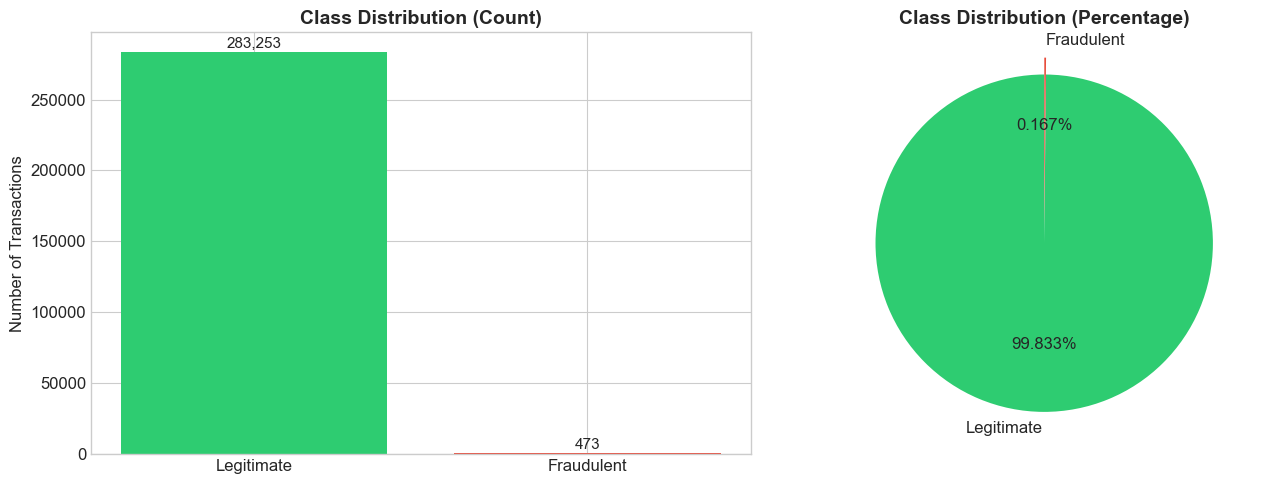


⚠️ The dataset is highly imbalanced! Only 0.173% of transactions are fraudulent.


In [8]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
colors = ['#2ecc71', '#e74c3c']
ax1 = axes[0]
bars = ax1.bar(['Legitimate', 'Fraudulent'], [class_counts[0], class_counts[1]], color=colors)
ax1.set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Transactions')
for bar, count in zip(bars, [class_counts[0], class_counts[1]]):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
             f'{count:,}', ha='center', va='bottom', fontsize=11)

# Pie chart
ax2 = axes[1]
wedges, texts, autotexts = ax2.pie([class_percentages[0], class_percentages[1]], 
                                    labels=['Legitimate', 'Fraudulent'],
                                    autopct='%1.3f%%',
                                    colors=colors,
                                    explode=(0, 0.1),
                                    startangle=90)
ax2.set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/plots/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n⚠️ The dataset is highly imbalanced! Only 0.173% of transactions are fraudulent.")

### 2.5 Feature Analysis

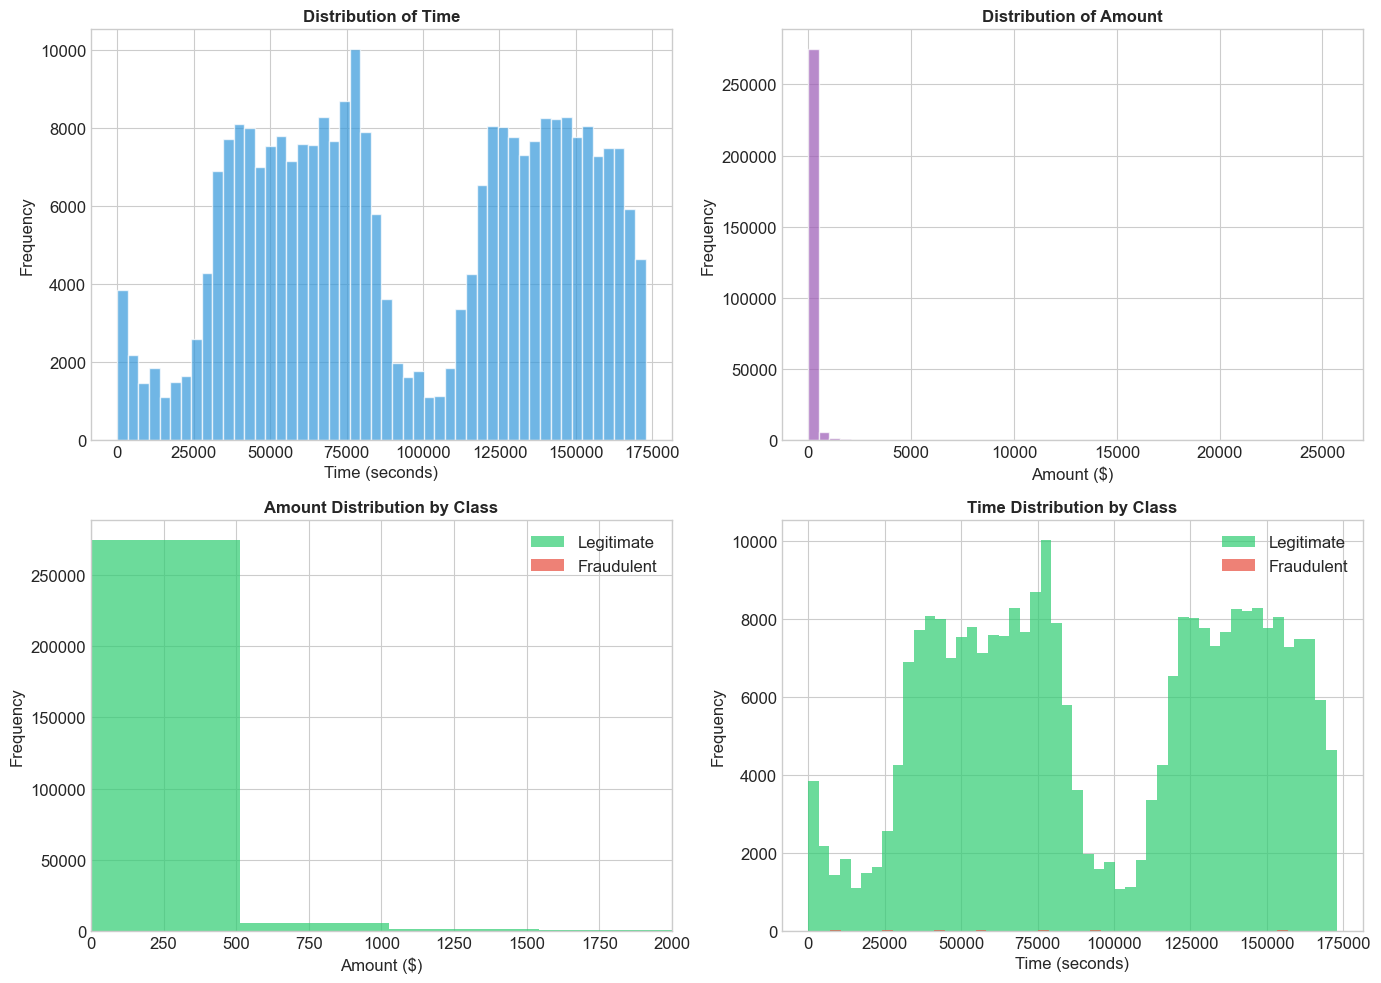

In [9]:
# Analyze Time and Amount features (the only non-PCA features)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time distribution
ax1 = axes[0, 0]
ax1.hist(df['Time'], bins=50, color='#3498db', edgecolor='white', alpha=0.7)
ax1.set_title('Distribution of Time', fontsize=12, fontweight='bold')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Frequency')

# Amount distribution
ax2 = axes[0, 1]
ax2.hist(df['Amount'], bins=50, color='#9b59b6', edgecolor='white', alpha=0.7)
ax2.set_title('Distribution of Amount', fontsize=12, fontweight='bold')
ax2.set_xlabel('Amount ($)')
ax2.set_ylabel('Frequency')

# Amount by class
ax3 = axes[1, 0]
ax3.hist(df[df['Class']==0]['Amount'], bins=50, alpha=0.7, label='Legitimate', color='#2ecc71')
ax3.hist(df[df['Class']==1]['Amount'], bins=50, alpha=0.7, label='Fraudulent', color='#e74c3c')
ax3.set_title('Amount Distribution by Class', fontsize=12, fontweight='bold')
ax3.set_xlabel('Amount ($)')
ax3.set_ylabel('Frequency')
ax3.legend()
ax3.set_xlim(0, 2000)  # Focus on smaller amounts

# Time by class
ax4 = axes[1, 1]
ax4.hist(df[df['Class']==0]['Time'], bins=50, alpha=0.7, label='Legitimate', color='#2ecc71')
ax4.hist(df[df['Class']==1]['Time'], bins=50, alpha=0.7, label='Fraudulent', color='#e74c3c')
ax4.set_title('Time Distribution by Class', fontsize=12, fontweight='bold')
ax4.set_xlabel('Time (seconds)')
ax4.set_ylabel('Frequency')
ax4.legend()

plt.tight_layout()
plt.savefig('../outputs/plots/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
# Statistical comparison of Amount between classes
print("Amount Statistics by Class:")
print("-" * 50)
print("\nLegitimate Transactions:")
print(df[df['Class']==0]['Amount'].describe())
print("\nFraudulent Transactions:")
print(df[df['Class']==1]['Amount'].describe())

Amount Statistics by Class:
--------------------------------------------------

Legitimate Transactions:
count    283253.000000
mean         88.413575
std         250.379023
min           0.000000
25%           5.670000
50%          22.000000
75%          77.460000
max       25691.160000
Name: Amount, dtype: float64

Fraudulent Transactions:
count     473.000000
mean      123.871860
std       260.211041
min         0.000000
25%         1.000000
50%         9.820000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


### 2.6 Correlation Analysis

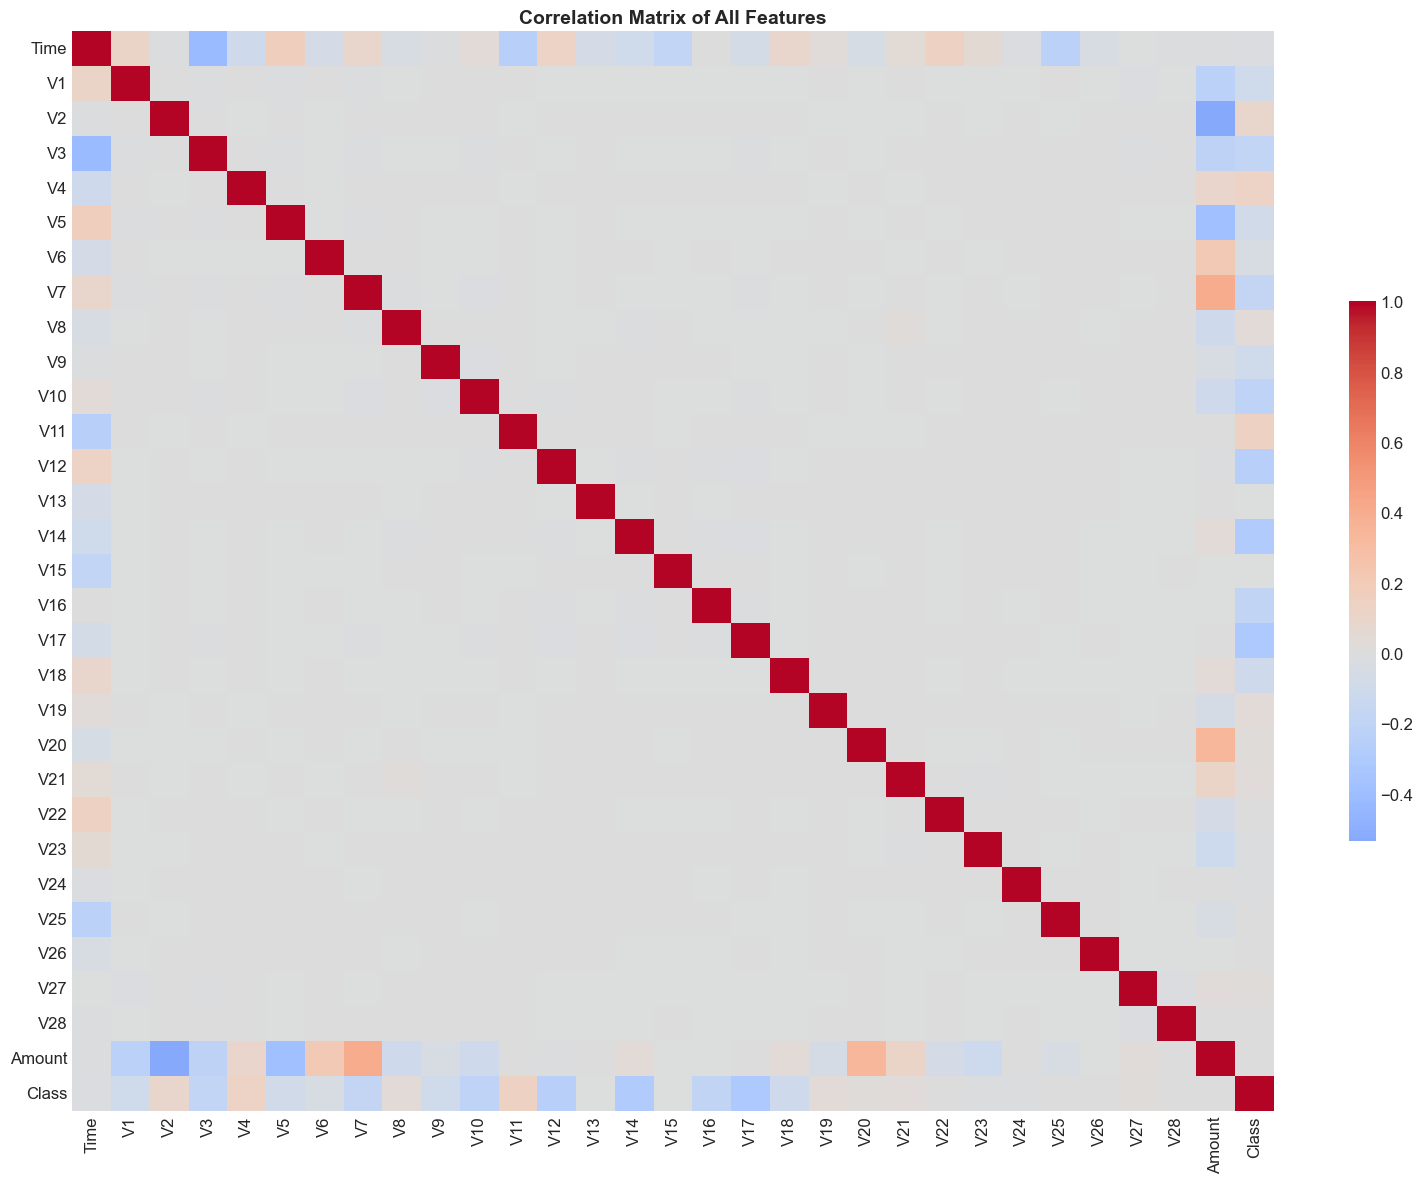

In [11]:
# Correlation matrix
plt.figure(figsize=(16, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, 
            xticklabels=True, yticklabels=True, 
            cbar_kws={'shrink': 0.5})
plt.title('Correlation Matrix of All Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/plots/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Features most correlated with Class
class_correlations = correlation_matrix['Class'].drop('Class').sort_values(key=abs, ascending=False)
print("Top 10 Features Most Correlated with Fraud:")
print("-" * 40)
print(class_correlations.head(10).to_string())

Top 10 Features Most Correlated with Fraud:
----------------------------------------
V17   -0.313498
V14   -0.293375
V12   -0.250711
V10   -0.206971
V16   -0.187186
V3    -0.182322
V7    -0.172347
V11    0.149067
V4     0.129326
V18   -0.105340


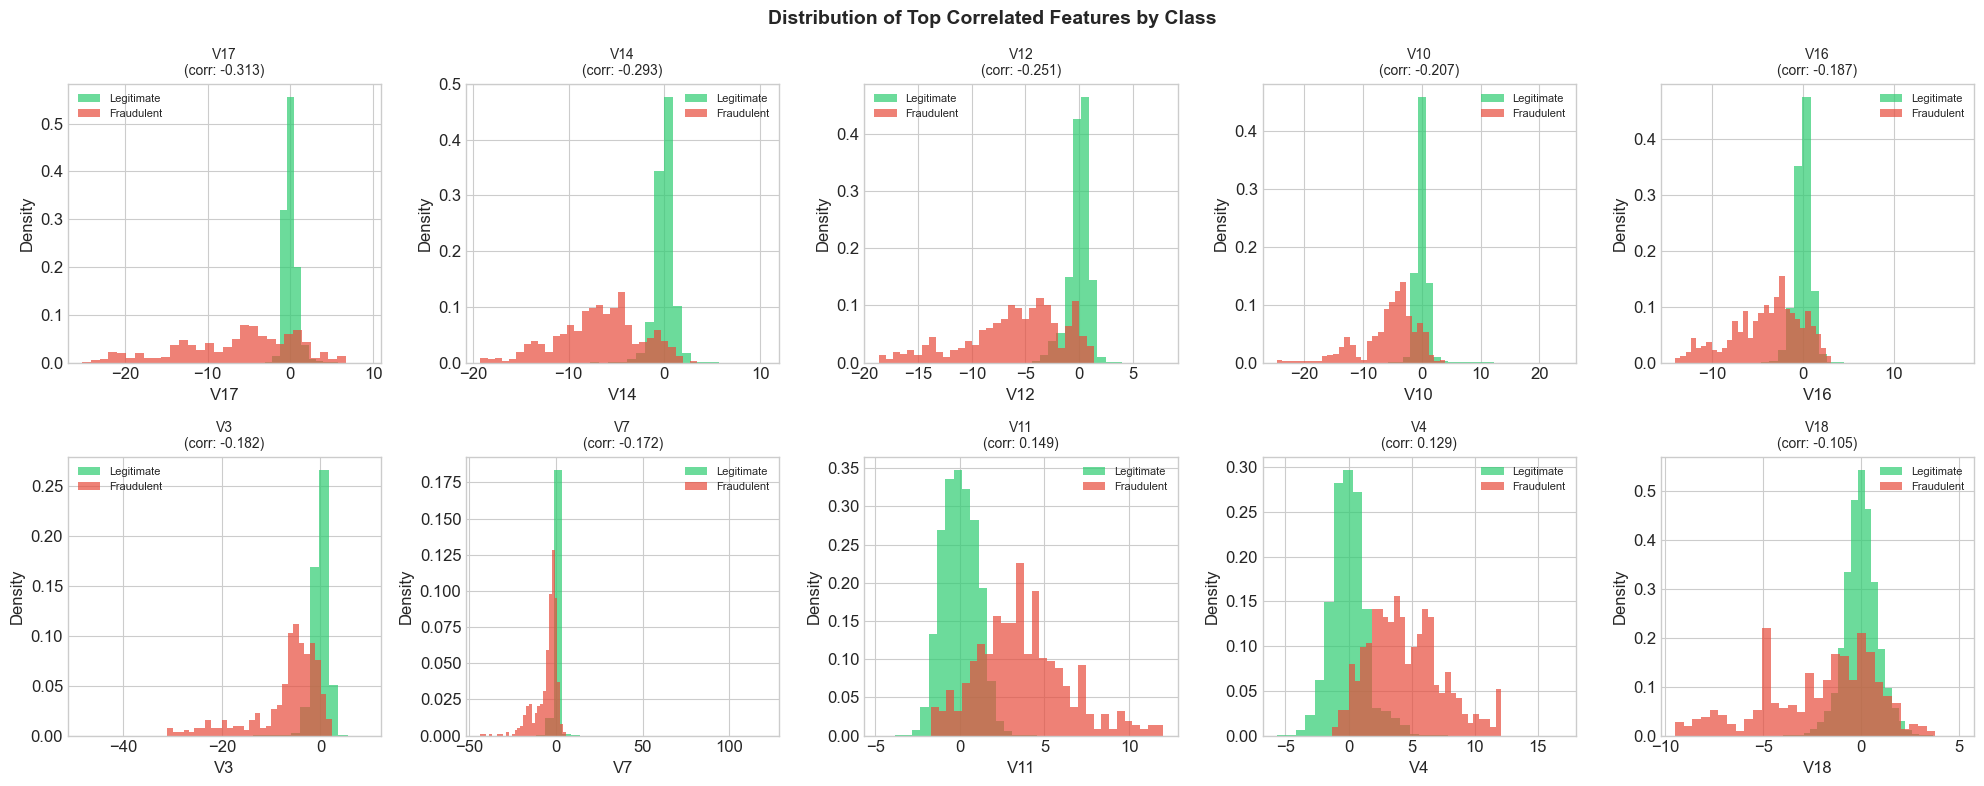

In [13]:
# Visualize top correlated features
top_features = class_correlations.head(10).index.tolist()

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    ax = axes[idx]
    ax.hist(df[df['Class']==0][feature], bins=30, alpha=0.7, label='Legitimate', color='#2ecc71', density=True)
    ax.hist(df[df['Class']==1][feature], bins=30, alpha=0.7, label='Fraudulent', color='#e74c3c', density=True)
    ax.set_title(f'{feature}\n(corr: {class_correlations[feature]:.3f})', fontsize=10)
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend(fontsize=8)

plt.suptitle('Distribution of Top Correlated Features by Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/plots/top_features_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Data Preprocessing

### 3.1 Feature Scaling

The V1-V28 features are already PCA-transformed and scaled. We only need to scale Time and Amount.

In [14]:
# Create a copy for preprocessing
df_processed = df.copy()

# Scale Amount and Time using RobustScaler (less sensitive to outliers)
scaler = RobustScaler()

df_processed['Amount'] = scaler.fit_transform(df_processed['Amount'].values.reshape(-1, 1))
df_processed['Time'] = scaler.fit_transform(df_processed['Time'].values.reshape(-1, 1))

print("Features scaled successfully!")
print("\nScaled Amount and Time statistics:")
df_processed[['Time', 'Amount']].describe()

Features scaled successfully!

Scaled Amount and Time statistics:


,Time,Amount
count,283726.000000,283726.000000
mean,0.118912,0.924387
std,0.557988,3.482123
min,-0.995290,-0.305938
25%,-0.358286,-0.228063
50%,0.000000,0.000000
75%,0.641714,0.771937
max,1.035329,356.962314


### 3.2 Train-Test Split

In [15]:
# Split features and target
X = df_processed.drop('Class', axis=1)
y = df_processed['Class']

# Stratified train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train-Test Split Results:")
print("-" * 40)
print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"\nTraining class distribution:")
print(f"  Legitimate: {(y_train==0).sum():,} ({(y_train==0).mean()*100:.3f}%)")
print(f"  Fraudulent: {(y_train==1).sum():,} ({(y_train==1).mean()*100:.3f}%)")
print(f"\nTest class distribution:")
print(f"  Legitimate: {(y_test==0).sum():,} ({(y_test==0).mean()*100:.3f}%)")
print(f"  Fraudulent: {(y_test==1).sum():,} ({(y_test==1).mean()*100:.3f}%)")

Train-Test Split Results:
----------------------------------------
Training set: 226,980 samples
Test set: 56,746 samples

Training class distribution:
  Legitimate: 226,602 (99.833%)
  Fraudulent: 378 (0.167%)

Test class distribution:
  Legitimate: 56,651 (99.833%)
  Fraudulent: 95 (0.167%)


## 4. Handling Imbalanced Data

We'll implement three different techniques to handle the class imbalance:
1. **SMOTE** (Synthetic Minority Over-sampling Technique)
2. **Random Under-sampling**
3. **SMOTE + Tomek Links** (Hybrid approach)

In [16]:
# Dictionary to store different resampled datasets
resampled_data = {}

# 1. SMOTE - Oversampling
print("Applying SMOTE (Synthetic Minority Over-sampling)...")
smote = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
resampled_data['SMOTE'] = (X_train_smote, y_train_smote)
print(f"  Original: {len(y_train):,} samples ({(y_train==1).sum():,} fraud)")
print(f"  After SMOTE: {len(y_train_smote):,} samples ({(y_train_smote==1).sum():,} fraud)")

# 2. Random Under-sampling
print("\nApplying Random Under-sampling...")
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
resampled_data['RUS'] = (X_train_rus, y_train_rus)
print(f"  Original: {len(y_train):,} samples ({(y_train==1).sum():,} fraud)")
print(f"  After RUS: {len(y_train_rus):,} samples ({(y_train_rus==1).sum():,} fraud)")

# 3. SMOTE + Tomek Links
print("\nApplying SMOTE + Tomek Links...")
smote_tomek = SMOTETomek(random_state=RANDOM_STATE)
X_train_st, y_train_st = smote_tomek.fit_resample(X_train, y_train)
resampled_data['SMOTE_Tomek'] = (X_train_st, y_train_st)
print(f"  Original: {len(y_train):,} samples ({(y_train==1).sum():,} fraud)")
print(f"  After SMOTE+Tomek: {len(y_train_st):,} samples ({(y_train_st==1).sum():,} fraud)")

# Also keep original data for comparison
resampled_data['Original'] = (X_train, y_train)

Applying SMOTE (Synthetic Minority Over-sampling)...
  Original: 226,980 samples (378 fraud)
  After SMOTE: 453,204 samples (226,602 fraud)

Applying Random Under-sampling...
  Original: 226,980 samples (378 fraud)
  After RUS: 756 samples (378 fraud)

Applying SMOTE + Tomek Links...
  Original: 226,980 samples (378 fraud)
  After SMOTE+Tomek: 453,204 samples (226,602 fraud)


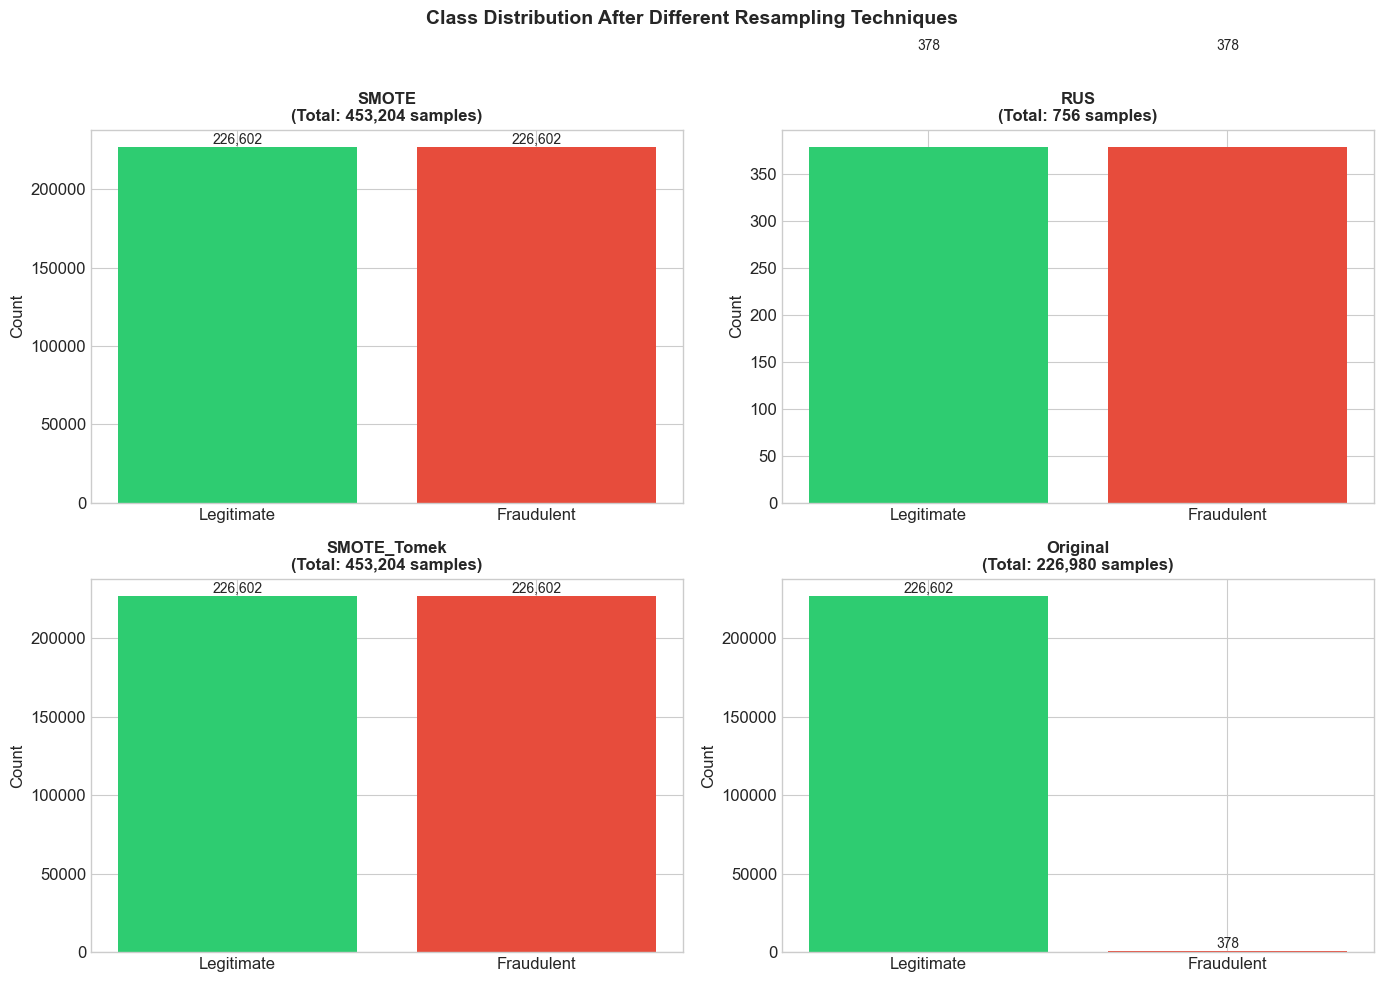

In [17]:
# Visualize resampling results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, (method, (X_res, y_res)) in enumerate(resampled_data.items()):
    ax = axes.flatten()[idx]
    counts = [sum(y_res==0), sum(y_res==1)]
    bars = ax.bar(['Legitimate', 'Fraudulent'], counts, color=['#2ecc71', '#e74c3c'])
    ax.set_title(f'{method}\n(Total: {len(y_res):,} samples)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Count')
    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
                f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Class Distribution After Different Resampling Techniques', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/plots/resampling_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Model Training

We'll train three different models:
1. **Logistic Regression** - Simple, interpretable baseline
2. **Random Forest** - Ensemble method with good performance
3. **XGBoost** - State-of-the-art gradient boosting

In [18]:
# Define models
def get_models():
    """Return dictionary of models to train."""
    models = {
        'Logistic Regression': LogisticRegression(
            max_iter=1000, 
            random_state=RANDOM_STATE,
            class_weight='balanced'
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=RANDOM_STATE,
            class_weight='balanced',
            n_jobs=-1
        ),
        'XGBoost': XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            random_state=RANDOM_STATE,
            scale_pos_weight=1,  # Will be adjusted based on data
            use_label_encoder=False,
            eval_metric='logloss',
            n_jobs=-1
        )
    }
    return models

print("Models defined successfully!")

Models defined successfully!


In [19]:
# Train all models on all resampled datasets
from time import time

# Store results
trained_models = {}
training_times = {}

print("Training models on different datasets...")
print("=" * 60)

for method, (X_train_res, y_train_res) in resampled_data.items():
    print(f"\n▶ Training on {method} dataset ({len(X_train_res):,} samples)")
    trained_models[method] = {}
    training_times[method] = {}
    
    # Calculate scale_pos_weight for XGBoost
    scale_pos_weight = (y_train_res == 0).sum() / (y_train_res == 1).sum()
    
    for model_name, model in get_models().items():
        print(f"  - Training {model_name}...", end=" ")
        
        # Update XGBoost scale_pos_weight
        if model_name == 'XGBoost':
            model.set_params(scale_pos_weight=scale_pos_weight)
        
        # Train model
        start_time = time()
        model.fit(X_train_res, y_train_res)
        train_time = time() - start_time
        
        trained_models[method][model_name] = model
        training_times[method][model_name] = train_time
        print(f"Done in {train_time:.2f}s")

print("\n" + "=" * 60)
print("All models trained successfully!")

Training models on different datasets...

▶ Training on SMOTE dataset (453,204 samples)
  - Training Logistic Regression... Done in 4.32s
  - Training Random Forest... Done in 86.35s
  - Training XGBoost... Done in 49.99s

▶ Training on RUS dataset (756 samples)
  - Training Logistic Regression... Done in 0.04s
  - Training Random Forest... Done in 0.43s
  - Training XGBoost... Done in 11.76s

▶ Training on SMOTE_Tomek dataset (453,204 samples)
  - Training Logistic Regression... Done in 4.12s
  - Training Random Forest... Done in 61.08s
  - Training XGBoost... Done in 6.32s

▶ Training on Original dataset (226,980 samples)
  - Training Logistic Regression... Done in 1.61s
  - Training Random Forest... Done in 25.33s
  - Training XGBoost... Done in 5.96s

All models trained successfully!


## 6. Model Evaluation

### 6.1 Evaluation Functions

In [20]:
def evaluate_model(model, X_test, y_test):
    """Calculate comprehensive evaluation metrics."""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
        'PR-AUC': average_precision_score(y_test, y_pred_proba)
    }
    
    return metrics, y_pred, y_pred_proba

def plot_confusion_matrix(y_test, y_pred, title, ax):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Legitimate', 'Fraudulent'],
                yticklabels=['Legitimate', 'Fraudulent'])
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

from sklearn.metrics import average_precision_score

print("Evaluation functions defined!")

Evaluation functions defined!


### 6.2 Evaluate All Models

In [21]:
# Evaluate all models
results = []

for method, models in trained_models.items():
    for model_name, model in models.items():
        metrics, y_pred, y_pred_proba = evaluate_model(model, X_test, y_test)
        
        results.append({
            'Resampling': method,
            'Model': model_name,
            'Training Time (s)': training_times[method][model_name],
            **metrics
        })

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score', ascending=False)

print("Model Evaluation Results:")
print("=" * 100)
results_df

Model Evaluation Results:


,Resampling,Model,Training Time (s),Accuracy,Precision,Recall,F1-Score,ROC-AUC,PR-AUC
10,Original,Random Forest,25.327698,0.999401,0.886076,0.736842,0.804598,0.964415,0.767141
11,Original,XGBoost,5.955801,0.999348,0.815217,0.789474,0.802139,0.965029,0.811091
1,SMOTE,Random Forest,86.349848,0.998802,0.606299,0.810526,0.693694,0.978590,0.791616
7,SMOTE_Tomek,Random Forest,61.075856,0.998802,0.606299,0.810526,0.693694,0.978590,0.791616
2,SMOTE,XGBoost,49.986169,0.997903,0.433333,0.821053,0.567273,0.973213,0.805380
8,SMOTE_Tomek,XGBoost,6.324263,0.997903,0.433333,0.821053,0.567273,0.973213,0.805380
4,RUS,Random Forest,0.428120,0.984316,0.086368,0.873684,0.157197,0.975974,0.695711
9,Original,Logistic Regression,1.608704,0.975311,0.056386,0.873684,0.105935,0.965679,0.671934
6,SMOTE_Tomek,Logistic Regression,4.117822,0.974113,0.053896,0.873684,0.101529,0.960061,0.671435
0,SMOTE,Logistic Regression,4.322744,0.974113,0.053896,0.873684,0.101529,0.960061,0.671435


### 6.3 Confusion Matrices

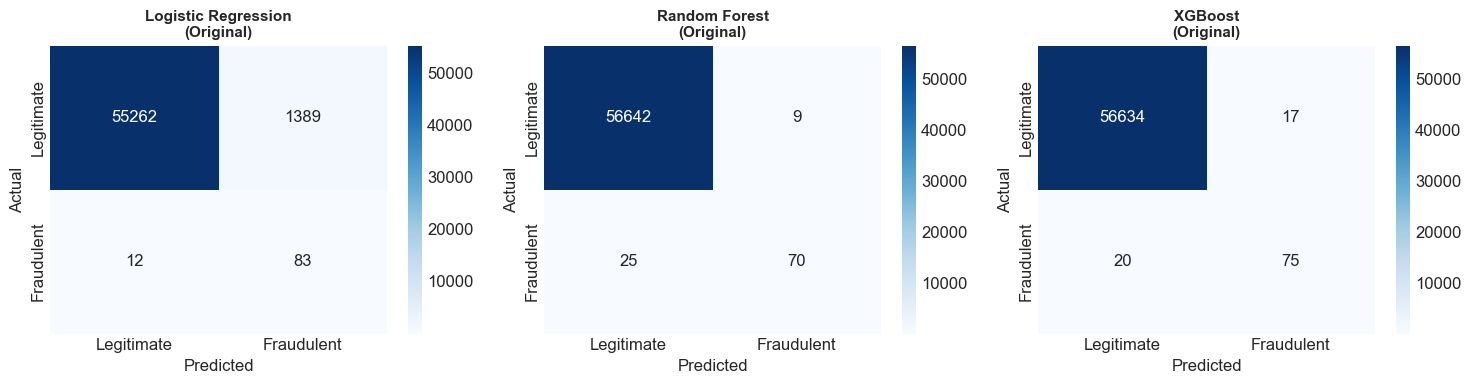

In [22]:
# Plot confusion matrices for best configuration of each model
best_per_model = results_df.groupby('Model').first().reset_index()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, row in best_per_model.iterrows():
    model = trained_models[row['Resampling']][row['Model']]
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, 
                          f"{row['Model']}\n({row['Resampling']})", 
                          axes[idx])

plt.tight_layout()
plt.savefig('../outputs/plots/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

### 6.4 ROC Curves

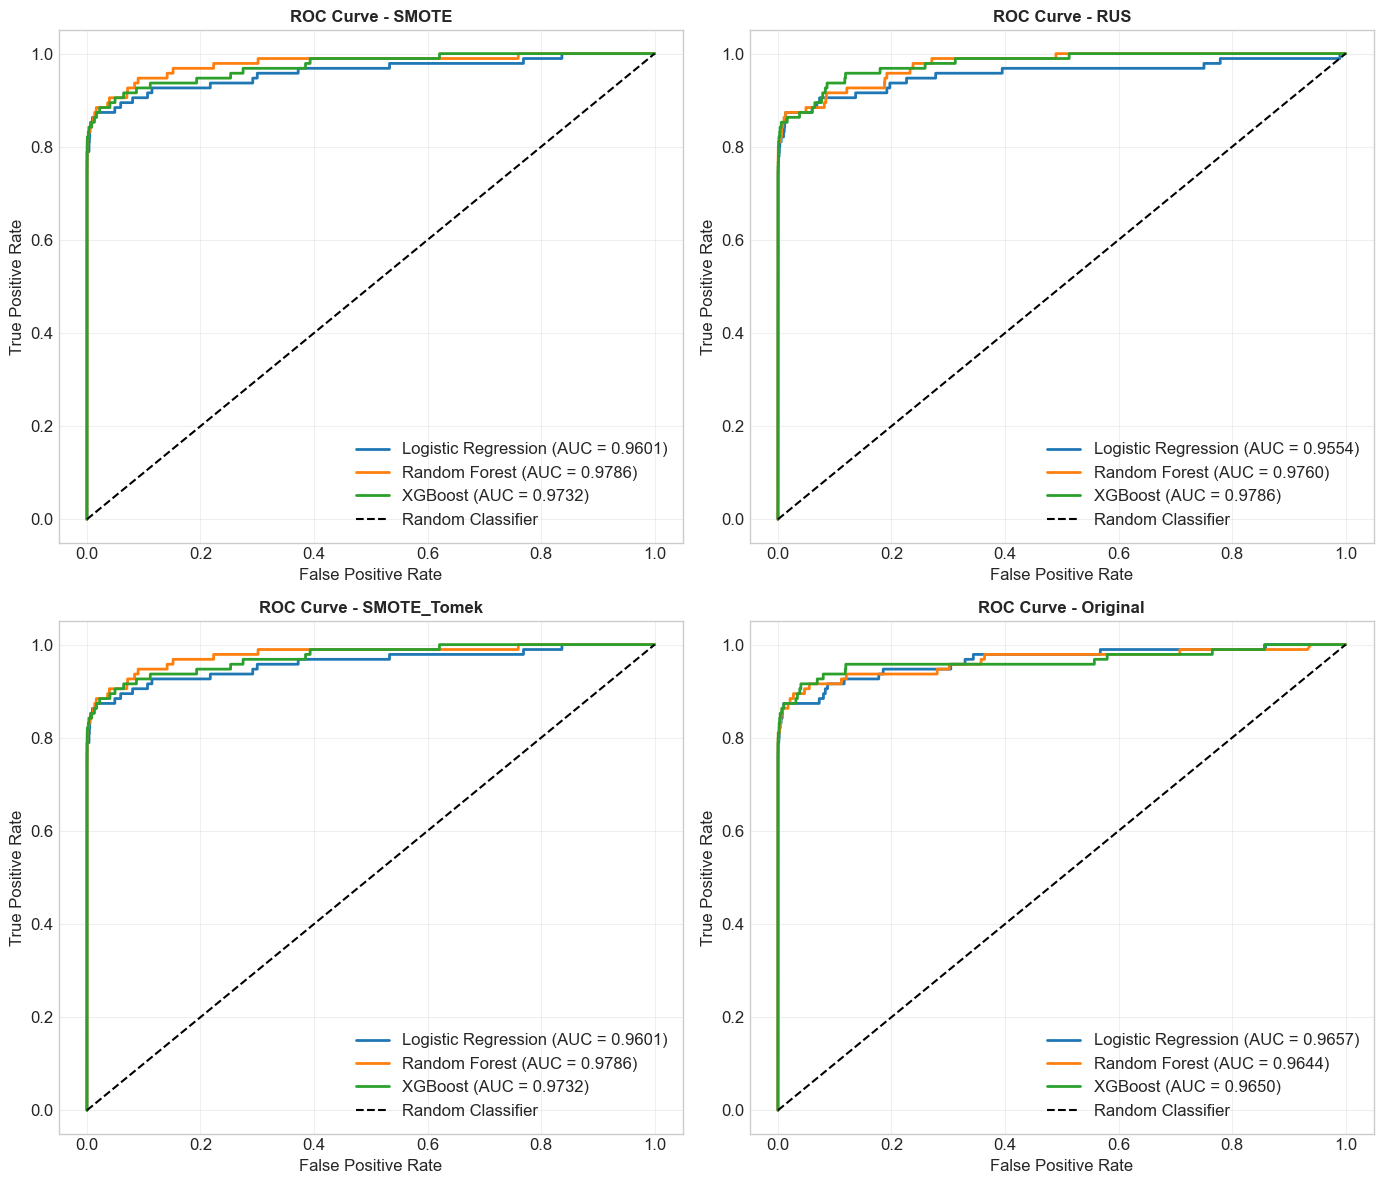

In [23]:
# Plot ROC curves for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for idx, (method, models) in enumerate(trained_models.items()):
    ax = axes.flatten()[idx]
    
    for model_name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        ax.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})', linewidth=2)
    
    ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {method}', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/plots/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

### 6.5 Precision-Recall Curves

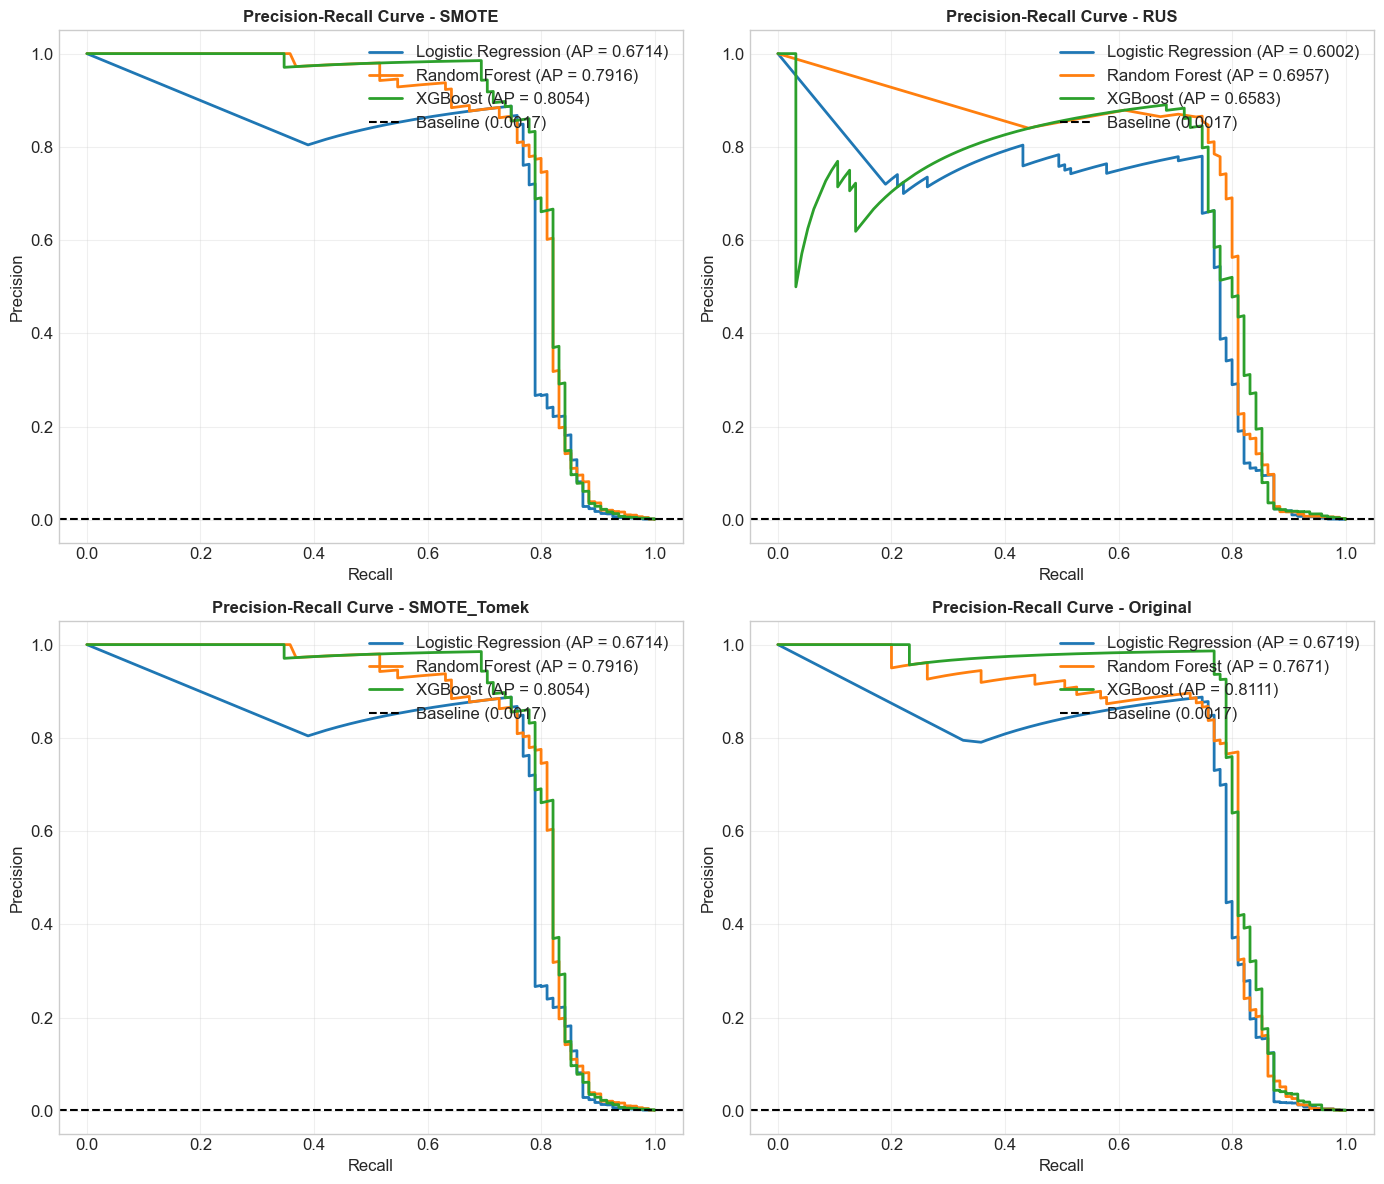

In [24]:
# Plot Precision-Recall curves
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for idx, (method, models) in enumerate(trained_models.items()):
    ax = axes.flatten()[idx]
    
    for model_name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        pr_auc = average_precision_score(y_test, y_pred_proba)
        
        ax.plot(recall, precision, label=f'{model_name} (AP = {pr_auc:.4f})', linewidth=2)
    
    # Baseline (proportion of positive class)
    baseline = y_test.mean()
    ax.axhline(y=baseline, color='k', linestyle='--', label=f'Baseline ({baseline:.4f})')
    
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve - {method}', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/plots/pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

### 6.6 Feature Importance

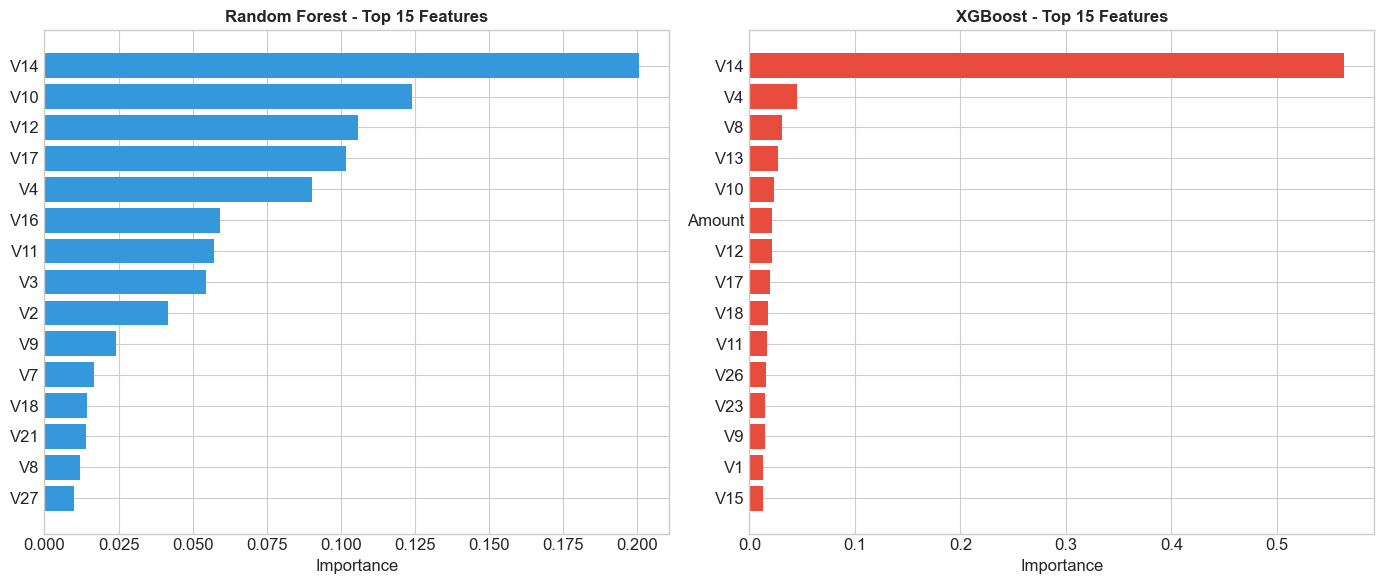

In [25]:
# Feature importance for tree-based models
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest feature importance
rf_model = trained_models['SMOTE']['Random Forest']
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=True)

axes[0].barh(rf_importance['Feature'].tail(15), rf_importance['Importance'].tail(15), color='#3498db')
axes[0].set_title('Random Forest - Top 15 Features', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Importance')

# XGBoost feature importance
xgb_model = trained_models['SMOTE']['XGBoost']
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=True)

axes[1].barh(xgb_importance['Feature'].tail(15), xgb_importance['Importance'].tail(15), color='#e74c3c')
axes[1].set_title('XGBoost - Top 15 Features', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.savefig('../outputs/plots/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Results Summary

### 7.1 Best Model Selection

In [26]:
# Find best model based on F1-Score
best_result = results_df.iloc[0]
print("🏆 BEST MODEL")
print("=" * 60)
print(f"Model: {best_result['Model']}")
print(f"Resampling Technique: {best_result['Resampling']}")
print(f"\nPerformance Metrics:")
print(f"  - Accuracy:  {best_result['Accuracy']:.4f}")
print(f"  - Precision: {best_result['Precision']:.4f}")
print(f"  - Recall:    {best_result['Recall']:.4f}")
print(f"  - F1-Score:  {best_result['F1-Score']:.4f}")
print(f"  - ROC-AUC:   {best_result['ROC-AUC']:.4f}")
print(f"  - PR-AUC:    {best_result['PR-AUC']:.4f}")
print(f"\nTraining Time: {best_result['Training Time (s)']:.2f} seconds")

🏆 BEST MODEL
Model: Random Forest
Resampling Technique: Original

Performance Metrics:
  - Accuracy:  0.9994
  - Precision: 0.8861
  - Recall:    0.7368
  - F1-Score:  0.8046
  - ROC-AUC:   0.9644
  - PR-AUC:    0.7671

Training Time: 25.33 seconds


### 7.2 Model Comparison Summary

In [27]:
# Create summary table
summary_table = results_df.pivot_table(
    index='Model',
    columns='Resampling',
    values='F1-Score',
    aggfunc='first'
)

print("F1-Score Comparison (Model vs Resampling Technique):")
print("=" * 70)
summary_table

F1-Score Comparison (Model vs Resampling Technique):


Resampling,Original,RUS,SMOTE,SMOTE_Tomek
Model,,,,
Logistic Regression,0.105935,0.095898,0.101529,0.101529
Random Forest,0.804598,0.157197,0.693694,0.693694
XGBoost,0.802139,0.100799,0.567273,0.567273


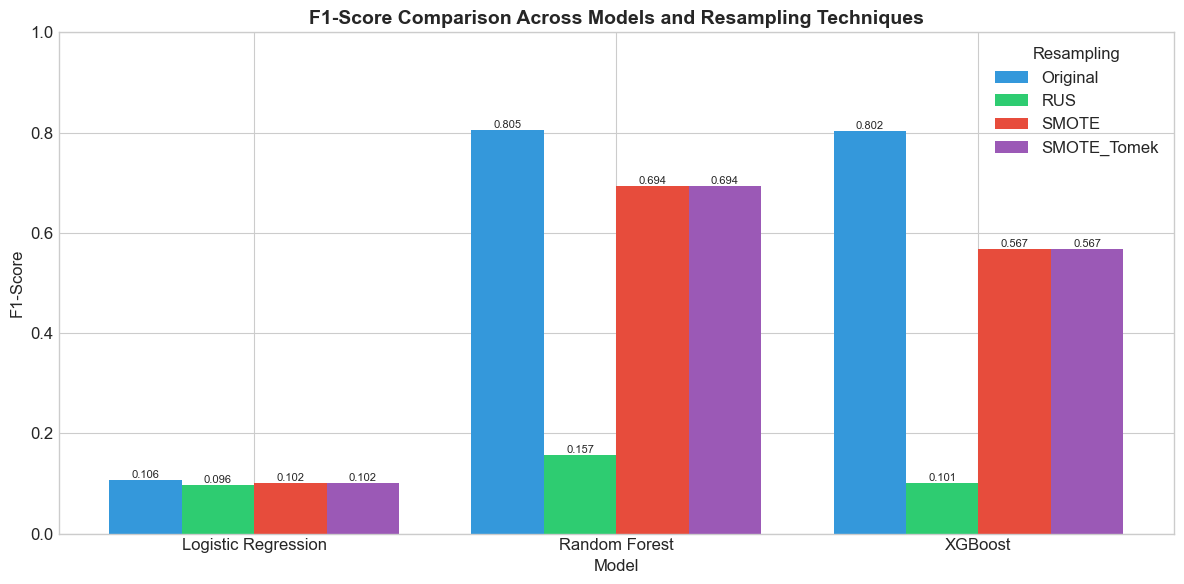

In [28]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(summary_table.index))
width = 0.2
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

for idx, col in enumerate(summary_table.columns):
    bars = ax.bar(x + idx * width, summary_table[col], width, label=col, color=colors[idx])
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Model')
ax.set_ylabel('F1-Score')
ax.set_title('F1-Score Comparison Across Models and Resampling Techniques', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(summary_table.index)
ax.legend(title='Resampling')
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('../outputs/plots/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### 7.3 Key Insights

In [29]:
print("📊 KEY INSIGHTS")
print("=" * 60)

# Best resampling technique
best_resampling = results_df.groupby('Resampling')['F1-Score'].mean().sort_values(ascending=False)
print(f"\n1. Best Resampling Technique (by average F1-Score):")
for method, score in best_resampling.items():
    print(f"   - {method}: {score:.4f}")

# Best model
best_model = results_df.groupby('Model')['F1-Score'].mean().sort_values(ascending=False)
print(f"\n2. Best Model (by average F1-Score):")
for model, score in best_model.items():
    print(f"   - {model}: {score:.4f}")

# Trade-off analysis
print(f"\n3. Precision-Recall Trade-off:")
print(f"   - High Recall: Better for catching all fraud (fewer false negatives)")
print(f"   - High Precision: Better for reducing false alarms (fewer false positives)")
print(f"   - Best F1-Score balances both: {best_result['Model']} with {best_result['Resampling']}")

# Top features
print(f"\n4. Most Important Features for Fraud Detection:")
for idx, row in xgb_importance.tail(5).iloc[::-1].iterrows():
    print(f"   - {row['Feature']}: {row['Importance']:.4f}")

📊 KEY INSIGHTS

1. Best Resampling Technique (by average F1-Score):
   - Original: 0.5709
   - SMOTE: 0.4542
   - SMOTE_Tomek: 0.4542
   - RUS: 0.1180

2. Best Model (by average F1-Score):
   - Random Forest: 0.5873
   - XGBoost: 0.5094
   - Logistic Regression: 0.1012

3. Precision-Recall Trade-off:
   - High Recall: Better for catching all fraud (fewer false negatives)
   - High Precision: Better for reducing false alarms (fewer false positives)
   - Best F1-Score balances both: Random Forest with Original

4. Most Important Features for Fraud Detection:
   - V14: 0.5637
   - V4: 0.0454
   - V8: 0.0310
   - V13: 0.0269
   - V10: 0.0232


### 7.4 Save Results

In [30]:
import joblib
import os

# Create output directories
os.makedirs('../outputs/models', exist_ok=True)
os.makedirs('../outputs/reports', exist_ok=True)

# Save best model
best_model_obj = trained_models[best_result['Resampling']][best_result['Model']]
joblib.dump(best_model_obj, '../outputs/models/best_model.joblib')
print(f"✅ Best model saved to: outputs/models/best_model.joblib")

# Save results
results_df.to_csv('../outputs/reports/model_comparison.csv', index=False)
print(f"✅ Results saved to: outputs/reports/model_comparison.csv")

# Save summary report
with open('../outputs/reports/summary_report.txt', 'w') as f:
    f.write("CREDIT CARD FRAUD DETECTION - SUMMARY REPORT\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Best Model: {best_result['Model']}\n")
    f.write(f"Resampling Technique: {best_result['Resampling']}\n\n")
    f.write("Performance Metrics:\n")
    f.write(f"  - Accuracy:  {best_result['Accuracy']:.4f}\n")
    f.write(f"  - Precision: {best_result['Precision']:.4f}\n")
    f.write(f"  - Recall:    {best_result['Recall']:.4f}\n")
    f.write(f"  - F1-Score:  {best_result['F1-Score']:.4f}\n")
    f.write(f"  - ROC-AUC:   {best_result['ROC-AUC']:.4f}\n")
    f.write(f"  - PR-AUC:    {best_result['PR-AUC']:.4f}\n")
print(f"✅ Summary report saved to: outputs/reports/summary_report.txt")

✅ Best model saved to: outputs/models/best_model.joblib
✅ Results saved to: outputs/reports/model_comparison.csv
✅ Summary report saved to: outputs/reports/summary_report.txt


## Conclusion

This notebook implemented a comprehensive Credit Card Fraud Detection system with the following components:

1. **Data Exploration**: Analyzed the highly imbalanced dataset (0.173% fraud)
2. **Preprocessing**: Scaled features and performed stratified train-test split
3. **Imbalance Handling**: Implemented SMOTE, Random Under-sampling, and SMOTE+Tomek
4. **Model Training**: Trained Logistic Regression, Random Forest, and XGBoost
5. **Evaluation**: Comprehensive metrics including ROC-AUC, PR-AUC, and F1-Score

### Recommendations

- **For Production**: Use the best model with appropriate threshold tuning based on business requirements
- **For Real-time Detection**: Consider model latency and implement batch processing
- **For Continuous Improvement**: Implement model monitoring and retraining pipeline